In [1]:
'''

根据路路建议，看看音调之间能不能直接进行decoding。

而且我要考虑 随机组合，两个音调之间，三个音调，四个音调

'''


'\n\n根据路路建议，看看音调之间能不能直接进行decoding。\n\n而且我要考虑 随机组合，两个音调之间，三个音调，四个音调\n\n'

In [1]:

import numpy as np
import os.path as op
from pandas import read_csv
import mne
from mne.io import read_raw_fif
from mne.datasets import visual_92_categories
from neurora.nps_cal import nps
from neurora.rdm_cal import eegRDM
from neurora.rdm_corr import rdm_correlation_spearman
from neurora.corr_cal_by_rdm import rdms_corr
from neurora.rsa_plot import plot_rdm, plot_corrs_by_time, plot_nps_hotmap, plot_corrs_hotmap
from neurora.decoding import tbyt_decoding_kfold
from neurora.rsa_plot import plot_tbyt_decoding_acc
import matplotlib.pyplot as plt


In [2]:
list_epochs_all = list()

sub_ids = [

    "pre2001","pre2002","pre2003","pre2004","pre2005",

]
file_path = 'E:\实验\阅读困难\数据处理\pre2beishi_RSA_ASSR46\data\\6epoch_clean_RSA\\'

for sub_id in sub_ids:
    data_path = file_path + sub_id + '_RSA-epo.fif'
    epochs_all = mne.read_epochs(fname=data_path)
    #做decoding要考虑被试内每个条件试次一样，如果被试间不一样可以用循环来解决。
    epochs_all.equalize_event_counts(method='mintime')
    list_epochs_all.append(epochs_all)

# 如果只想看某一部分的脑区,配合更改ndarray的维度
# channels_nieye = ['M1','T7','P7','TP7','M2','T8','P8','TP8','CP5','CP6','C5','C6']
# epochs_nieye = epochs_all.pick(picks=channels_nieye)

'''
思路，先求ERP，然后再给ndarray，然后再计算RDM
'''

Reading E:\实验\阅读困难\数据处理\pre2beishi_RSA_ASSR46\data\6epoch_clean_RSA\pre2001_RSA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
1733 matching events found
No baseline correction applied
0 projection items activated
Dropped 33 epochs: 0, 25, 515, 546, 553, 570, 571, 576, 581, 1055, 1083, 1120, 1127, 1138, 1151, 1154, 1156, 1247, 1258, 1260, 1341, 1365, 1368, 1372, 1389, 1447, 1466, 1486, 1600, 1670, 1672, 1698, 1725
Reading E:\实验\阅读困难\数据处理\pre2beishi_RSA_ASSR46\data\6epoch_clean_RSA\pre2002_RSA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
1722 matching events found
No baseline correction applied
0 projection items activated
Dropped 42 epochs: 2, 8, 9, 23, 31, 38, 50, 58, 63, 116, 119, 165, 382, 444, 479, 486, 494, 503, 580, 623, 652, 657, 779, 820, 838, 940, 1145, 1163, 1632, 164

'\n思路，先求ERP，然后再给ndarray，然后再计算RDM\n'

In [3]:
'''
单独处理一下被试 pre2002，改一下channel属性
'''
chan_types_dict = { "VEOG":"eog","HEOG":"eog"}
list_epochs_all[1].set_channel_types(chan_types_dict)

Number of events,1680
Events,101: 84102: 84103: 84104: 84111: 84112: 84113: 84114: 84121: 84122: 84123: 84124: 84131: 84132: 84133: 84134: 84141: 84142: 84143: 84144: 84
Time range,-0.200 – 0.800 sec
Baseline,-0.200 – 0.000 sec


In [4]:
'''
先整理单个的被试看看

data的结构要求： [n_subs, n_trials, n_chls, n_ts]
label的结构要求： [n_subs, n_trials]

'''

conds = ['101', '102', '103', '104', '111', '112', '113', '114', '121', '122', '123', '124', '131', '132', '133', '134', '141', '142', '143', '144']


#初始值
subindex = 0
list_subdata = list()
list_sublabel = list()
for m in range(len(sub_ids)):
    #单个被试的数据
    epochs_forlen = list_epochs_all[m][conds[0]]
    # 每个被试的trial数量是不一样的
    # trial数不能放在第一位，第一位是condition
    num_trials = len(epochs_forlen.events[:,1])
    subdata = np.zeros([20, num_trials, 62,  1001], dtype=np.float32)
    sublabel = np.zeros([0,0])

    for i in range(len(conds)):
        epochs = list_epochs_all[m][conds[i]]
        #做decoding，这里就不能是平均了吧。
        # 这里get_data()还会把所有的channel都选上，你需要pick一下,只要eeg，不要眼动数据
        data = epochs.get_data(picks='eeg')
        label_cond = epochs.events[:,2]
        #每种条件的cond
        sublabel = np.append(sublabel,label_cond)
        sublabel = np.reshape(sublabel, [1,len(sublabel[:])])
        subdata[i] = data
        # 现在是[con, trial, chan, ts]
        # [n_cons, n_subs, n_trials, n_chls, n_ts]需要这样的结构
        # 需要中间插入一个subs
    subdata = np.reshape(subdata, [20, 1, num_trials, 62, 1001])
    # 在某个维度上面拉平
    # 把condition的维度乘到 trial上面？
    data_decode = np.reshape(subdata,[1, 20 * num_trials,  62, 1001])
    list_subdata.append(data_decode)
    list_sublabel.append(sublabel)

'''
对label进行处理，
让每个值都除以100，如果是辅音，那么就取商，如果是音调，那么就取余数。
'''


'\n对label进行处理，\n让每个值都除以100，如果是辅音，那么就取商，如果是音调，那么就取余数。\n'

In [70]:
# label_fuyin = ((sublabel-100)/10).astype(int)
# label_yindiao = ((sublabel-100)%10).astype(int)

# accs_fuyin = tbyt_decoding_kfold(data_decode,label_fuyin, n=5, time_win=50,time_step=5)
# accs_yindiao = tbyt_decoding_kfold(data_decode,label_yindiao, n=4, time_win=50,time_step=5)
# plt.plot(accs_fuyin[0,:])


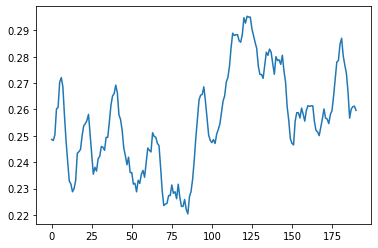

In [70]:

# plt.plot(accs_yindiao[0,:])

In [5]:
'''

每个被试trial数量不一致，所以只能循环求每个被试的accs再拼接

'''
n_subs = len(sub_ids)
n_ts = 191
accs_fuyin_allsubs = np.zeros([n_subs, n_ts])
accs_yindiao_allsubs = np.zeros([n_subs, n_ts])

# 音调

for i in range(len(sub_ids)):
    data_decode = list_subdata[i]
    label_original = list_sublabel[i]
    label_yindiao = ((label_original-100)%10).astype(int)
    accs_yindiao = tbyt_decoding_kfold(data_decode,label_yindiao, n=4, time_win=50,time_step=5, nfolds=5, nrepeats=20)
    accs_yindiao_allsubs[i] = accs_yindiao


Calculating: [====================================================================================================] 100.00%
Decoding finished!

Calculating: [====================================================================================================] 100.00%
Decoding finished!

Calculating: [====================================================================================================] 100.00%
Decoding finished!

Calculating: [====================================================================================================] 100.00%
Decoding finished!

Calculating: [====================================================================================================] 100.00%
Decoding finished!



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

data_decode_all = np.zeros([n_subs, n_ts])
label_yindiao_all = list()

for i in range(len(sub_ids)):
    data_decode = list_subdata[i]
    data_decode_all.append(data_decode)

    label_original = list_sublabel[i]
    label_yindiao = ((label_original-100)%10).astype(int)
    label_yindiao_all.append(label_yindiao.transpose())

    # accs_yindiao = tbyt_decoding_kfold(data_decode,label_yindiao, n=4, time_win=50,time_step=5, nfolds=5, nrepeats=20)
    # accs_yindiao_allsubs[i] = accs_yindiao

# We will train the classifier on all left visual vs auditory trials on MEG
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='liblinear')
)

time_decod = SlidingEstimator(
    clf, n_jobs=None, scoring='accuracy', verbose=True)
# here we use cv=3 just for speed
X = data_decode_all[0][0]
y = label_yindiao_all[0]
scores = cross_val_multiscore(time_decod, X, y, cv=3, n_jobs=None)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')



In [30]:

clf = make_pipeline(
    StandardScaler(),
    LinearModel(LogisticRegression(solver='liblinear'))
)
time_decod = SlidingEstimator(
    clf, n_jobs=None, scoring='accuracy', verbose=True)
time_decod.fit(X, y)


  0%|          | Fitting SlidingEstimator : 0/1001 [00:00<?,       ?it/s]

D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

<SlidingEstimator({'base_estimator': Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearmodel',
                 LinearModel({'model': LogisticRegression(solver='liblinear')}))]),
 'n_jobs': None,
 'scoring': 'accuracy',
 'verbose': None}, fitted with 1001 estimators>

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting GeneralizingEstimator : 0/1001 [00:00<?,       ?it/s]

D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

  0%|          | Scoring GeneralizingEstimator : 0/1002001 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 19.4min remaining:    0.0s


  0%|          | Fitting GeneralizingEstimator : 0/1001 [00:00<?,       ?it/s]

D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

  0%|          | Scoring GeneralizingEstimator : 0/1002001 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 38.9min remaining:    0.0s


  0%|          | Fitting GeneralizingEstimator : 0/1001 [00:00<?,       ?it/s]

D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

  0%|          | Scoring GeneralizingEstimator : 0/1002001 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 58.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 58.9min finished


Text(0.5, 1.0, 'Decoding MEG sensors over time')

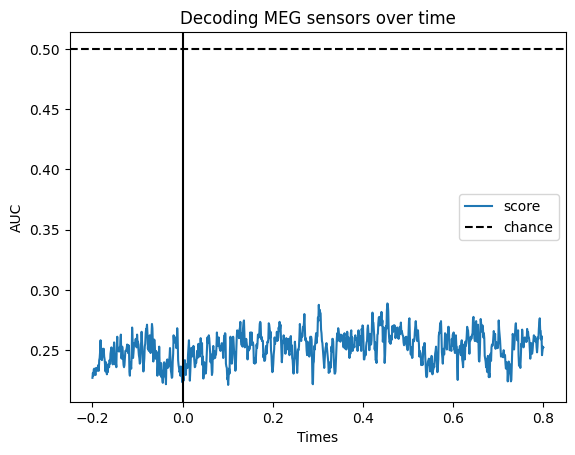

In [35]:

# define the Temporal generalization object
time_gen = GeneralizingEstimator(clf, n_jobs=None, scoring='accuracy',
                                 verbose=True)

# again, cv=3 just for speed
scores = cross_val_multiscore(time_gen, X, y, cv=3, n_jobs=None)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot the diagonal (it's exactly the same as the time-by-time decoding above)
fig, ax = plt.subplots()
ax.plot(epochs.times, np.diag(scores), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Decoding MEG sensors over time')


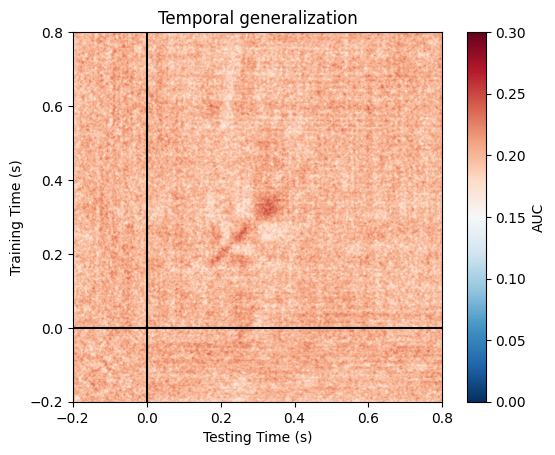

In [46]:

fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0., vmax=0.3)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('AUC')


In [26]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [ ]:


plot_tbyt_decoding_acc(accs_yindiao_allsubs, start_time=-0.2, end_time=0.755, time_interval=0.005, chance=0.25,color='blue', ylim=[0,0.5], xlim=[-0.2,0.8])


In [ ]:
# 辅音
for i in range(len(sub_ids)):
    data_decode = list_subdata[i]
    label_original = list_sublabel[i]
    # 区别在这里
    label_fuyin = ((label_original-100)/10).astype(int)
    accs_fuyin = tbyt_decoding_kfold(data_decode,label_fuyin, n=5, time_win=50,time_step=5, nfolds=5, nrepeats=20)
    accs_fuyin_allsubs[i] = accs_fuyin


plot_tbyt_decoding_acc(accs_fuyin_allsubs, start_time=-0.2, end_time=0.755, time_interval=0.005, chance=0.2, color='red', ylim=[0,0.5],xlim=[-0.2,0.8])



In [ ]:

# 辅音

data_decode_all = list()
label_yindiao_all = list()


for i in range(len(sub_ids)):
    data_decode = list_subdata[i]
    data_decode_all.append(data_decode)

    label_original = list_sublabel[i]
    label_yindiao =  ((label_original-100)/10).astype(int)
    label_yindiao_all.append(label_yindiao.transpose())

    # accs_yindiao = tbyt_decoding_kfold(data_decode,label_yindiao, n=4, time_win=50,time_step=5, nfolds=5, nrepeats=20)
    # accs_yindiao_allsubs[i] = accs_yindiao

# We will train the classifier on all left visual vs auditory trials on MEG
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='liblinear')
)

time_decod = SlidingEstimator(
    clf, n_jobs=None, scoring='accuracy', verbose=True)
# here we use cv=3 just for speed
X = data_decode_all[0][0]
y = label_yindiao_all[0]
scores = cross_val_multiscore(time_decod, X, y, cv=3, n_jobs=None)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')

clf = make_pipeline(
    StandardScaler(),
    LinearModel(LogisticRegression(solver='liblinear'))
)
time_decod = SlidingEstimator(
    clf, n_jobs=None, scoring='accuracy', verbose=True)
time_decod.fit(X, y)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting GeneralizingEstimator : 0/1001 [00:00<?,       ?it/s]

D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

  0%|          | Scoring GeneralizingEstimator : 0/1002001 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.0min remaining:    0.0s


  0%|          | Fitting GeneralizingEstimator : 0/1001 [00:00<?,       ?it/s]

D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

  0%|          | Scoring GeneralizingEstimator : 0/1002001 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 42.0min remaining:    0.0s


  0%|          | Fitting GeneralizingEstimator : 0/1001 [00:00<?,       ?it/s]

D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\anaconda\envs\mne\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

  0%|          | Scoring GeneralizingEstimator : 0/1002001 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 63.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 63.4min finished


Text(0.5, 1.0, 'Decoding MEG sensors over time')

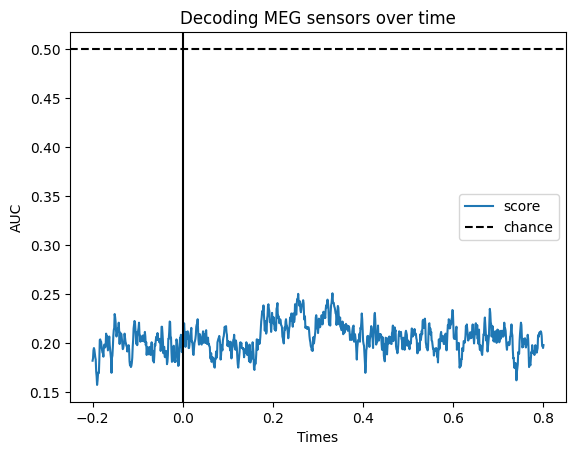

In [43]:


# define the Temporal generalization object
time_gen = GeneralizingEstimator(clf, n_jobs=None, scoring='accuracy',
                                 verbose=True)

# again, cv=3 just for speed
scores = cross_val_multiscore(time_gen, X, y, cv=3, n_jobs=None)

# Mean scores across cross-validation splits
# 所以算是下图在一个维度上的压缩。
scores = np.mean(scores, axis=0)

# Plot the diagonal (it's exactly the same as the time-by-time decoding above)
fig, ax = plt.subplots()
ax.plot(epochs.times, np.diag(scores), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Decoding MEG sensors over time')

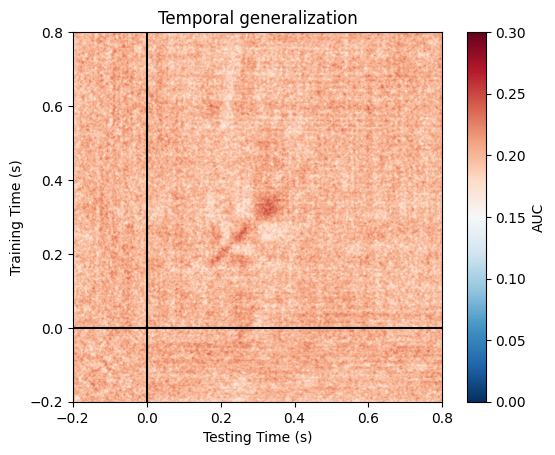

In [45]:

fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0., vmax=0.3)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('AUC')



Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!


Significant time-windows:
330ms to 514ms
575ms to 630ms
710ms to 1000ms


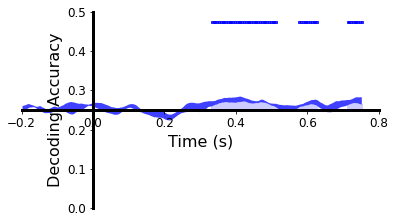

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [92]:
%matplotlib inline
